# Accounting for formation or storage loss in PyBaMM simulations
What if a PyBaMM parameter set exists for your cell, but the cell has lost capacity due to SEI formation or SEI growth during storage? It is easy to modify the parameters to account for this.

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import matplotlib.pyplot as plt

import pybamm

Note: you may need to restart the kernel to use updated packages.


Here, we model the effect of storage on the capacity of the LG M50 cell. [Chen et al. (2020)](https://iopscience.iop.org/article/10.1149/1945-7111/ab9050) measured a capacity of 5 Ah, but [Kirkaldy et al. (2022)](https://chemrxiv.org/engage/chemrxiv/article-details/622b8d933599deea00fc1f95) measured a smaller capacity of 4.865 Ah. [Li et al. (2025)](https://www.nature.com/articles/s41467-025-57968-3) assumed the discrepancy to be caused by SEI formation during storage and adjusted three parameters accordingly: initial negative electrode stoichiometry, SEI thickness and negative electrode porosity. First, print the original values of these parameters:

In [2]:
model = pybamm.lithium_ion.DFN({"SEI": "constant"})
param = pybamm.ParameterValues("Chen2020")
exp = pybamm.Experiment(["Discharge at 1C until 2.5 V"])
sim_original = pybamm.Simulation(model, parameter_values=param, experiment=exp)
sol_original = sim_original.solve()
c_max_n = param["Maximum concentration in negative electrode [mol.m-3]"]
c_init_n = param["Initial concentration in negative electrode [mol.m-3]"]
print(
    f"Before storage, the initial negative electrode stiochiometry is {100 * c_init_n / c_max_n}%."
)
L_SEI_0 = param["Initial SEI thickness [m]"]
print(f"Before storage, the SEI thickness is {L_SEI_0 * 1e9} nm.")
eps_neg = param["Negative electrode porosity"]
print(f"Before storage, the porosity is {eps_neg * 100}%.")

Before storage, the initial negative electrode stiochiometry is 90.13973983641687%.
Before storage, the SEI thickness is 5.0 nm.
Before storage, the porosity is 25.0%.


In [3]:
F = 96485.3
L_n = param["Negative electrode thickness [m]"]
L_y = param["Electrode width [m]"]
L_z = param["Electrode height [m]"]
V_n = L_n * L_y * L_z
R_n = param["Negative particle radius [m]"]
eps_act_n = param["Negative electrode active material volume fraction"]
a_n = 3 * eps_act_n / R_n
V_bar_SEI = param["SEI partial molar volume [m3.mol-1]"]
z_SEI = param["Ratio of lithium moles to SEI moles"]

Enter your storage loss here.

In [4]:
Delta_Q_Ah = 0.135  # From Li et al. (2025) via Kirkaldy et al. (2022). Change it and see what happens!

It is convieniently assumed here that all of the lost lithium comes out of the negative electrode, because this will not (usually) affect the voltage. If a change in voltage is measured - for example, during a formation cycle - the positive stoichiometry may also need to change.

In [5]:
c_SEI = Delta_Q_Ah * 3600 / (F * z_SEI * V_n)  # SEI concentration
Delta_c_n = (
    c_SEI * z_SEI / eps_act_n
)  # loss of lithium from negative electrode particles
c_init_degraded = c_init_n - Delta_c_n
print(
    f"After storage, the initial negative electrode stoichiometry is {100 * c_init_degraded / c_max_n}%."
)
L_SEI_0_degraded = c_SEI * V_bar_SEI / a_n
print(f"After storage, the SEI thickness is {L_SEI_0_degraded * 1e9} nm.")
eps_neg_degraded = eps_neg - L_SEI_0_degraded * a_n
print(f"After storage, the porosity is {eps_neg_degraded * 100}%.")
param_degraded = param.copy()
param_degraded.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": c_init_degraded,
        "Initial SEI thickness [m]": L_SEI_0_degraded,
        "Negative electrode porosity": eps_neg_degraded,
    }
)
sim_degraded = pybamm.Simulation(model, parameter_values=param_degraded, experiment=exp)
sol_degraded = sim_degraded.solve()

After storage, the initial negative electrode stoichiometry is 87.82318249083892%.
After storage, the SEI thickness is 71.85256873780948 nm.
After storage, the porosity is 22.24115563720015%.


Now we know exactly how much the parameters have changed during storage. Plot and compare:

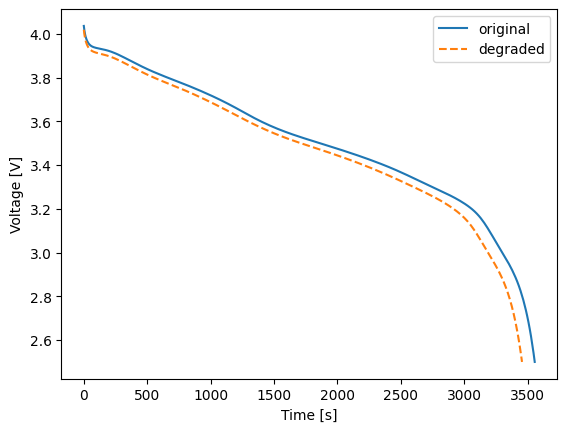

In [6]:
t_original = sol_original["Time [s]"].entries
V_original = sol_original["Voltage [V]"].entries
t_degraded = sol_degraded["Time [s]"].entries
V_degraded = sol_degraded["Voltage [V]"].entries
plt.figure()
plt.plot(t_original, V_original, label="original")
plt.plot(t_degraded, V_degraded, label="degraded", linestyle="dashed")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()

Inspection of the plot reveals the cell has lost the correct amount of capacity. In addition, we can plot the voltage components to see how much the change in porosity has affected the overpotentials:

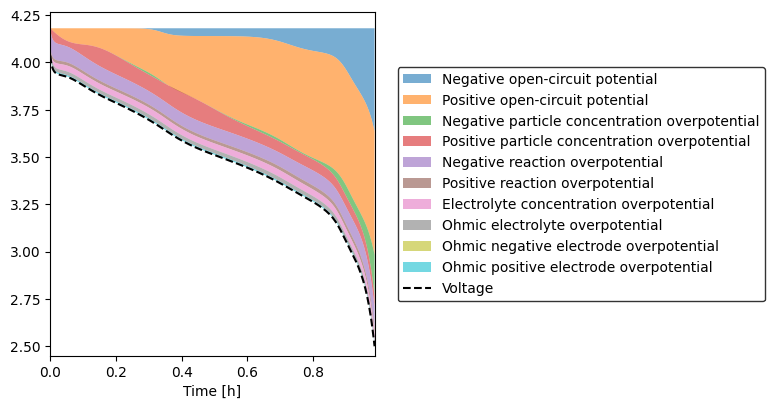

(<Figure size 800x400 with 1 Axes>, <Axes: xlabel='Time [h]'>)

In [7]:
sol_original.plot_voltage_components(split_by_electrode=True)

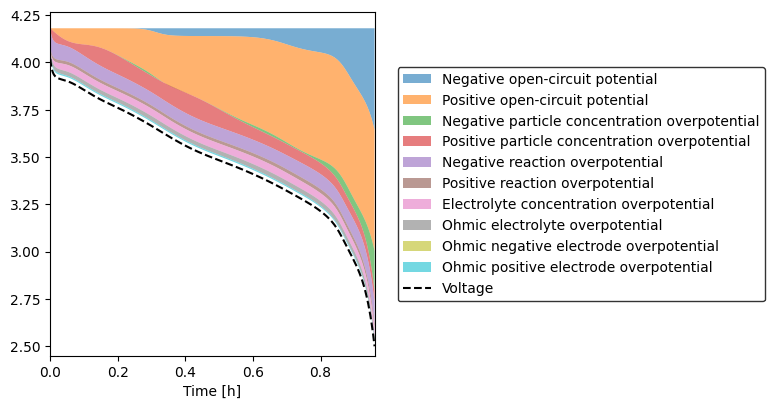

(<Figure size 800x400 with 1 Axes>, <Axes: xlabel='Time [h]'>)

In [8]:
sol_degraded.plot_voltage_components(split_by_electrode=True)

There is indeed a slight increase in the Ohmic and non-Ohmic electrolyte overpotentials. Note also that the voltage components no longer add up; this is due to the SEI film resistance, which is an additional overpotential that `plot_voltage_components` does not account for.

In [9]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[3] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[4] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. 